# LegacyHalos SersicFitting

This notebook demonstrates how we fit the 1D surface brightness profiles using various parametric (e.g., Sersic) models, using one galaxy as a toy example.

### Imports, paths, and other preliminaries.

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from legacyhalos import io
from legacyhalos.util import ellipse_sbprofile
from legacyhalos.qa import display_ellipse_sbprofile

In [3]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [4]:
pixscale = 0.262
band = ('g', 'r', 'z')
refband = 'r'

### Read the sample

In [5]:
sample = io.read_sample(istart=0, iend=1)

Read 1 galaxies


In [6]:
objid, objdir = io.get_objid(sample)
ellipsefit = io.read_ellipsefit(objid, objdir)
redshift = sample.z

### Surface brightness profile

In [7]:
sbprofile = ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                              redshift=redshift, pixscale=pixscale)

In [56]:
def sb2flux(sb):
    """Convert surface brightness to linear flux."""
    return [10**(-0.4 * _sb) for _sb in np.atleast_1d(sb)]

In [52]:
def fit_sersic(sbprofile, init_reff=10.0, init_n=2.0):
    from scipy.optimize import least_squares
    from astropy.modeling import models, fitting
    
    fixed = {'n': True}
    bounds = {}
    
    fit = fitting.LevMarLSQFitter()
    
    radius = sbprofile['sma']
    
    sersicfit = dict()
    for filt in band:
        mu = sb2flux(sbprofile['mu_{}'.format(filt)])
        mu_err = sb2flux(sbprofile['mu_{}_err'.format(filt)])
    
        init = models.Sersic1D(amplitude=sb2flux(mu.min()), 
                               r_eff=init_reff, n=init_n,
                               fixed=fixed, bounds=bounds)
        sersicfit[filt] = fit(init, radius, mu, weights=1/mu_err)
        import pdb ; pdb.set_trace()
        print(sersicfit[filt])

    return sersicfit

In [70]:
def lnprobfn(theta, residuals=False):
    """For now, just compute a vector of chi values, for use
    with non-linear least-squares algorithms.
    
    """
    from astropy.modeling import models
    if residuals:
        init = models.Sersic1D(amplitude=sb2flux(mu.min()), 
                               r_eff=init_reff, n=init_n,
                               fixed=fixed, bounds=bounds)
        
        

SyntaxError: unexpected EOF while parsing (<ipython-input-70-dce55afdbded>, line 8)

In [ ]:
def chivecfn(theta):
    """Return the residuals instead of the posterior probability or negative
    chisq, for use with least-squares optimization methods.
    """
    return lnprobfn(theta, residuals=True)

In [64]:
def minimizer_ball(guess, nmin=5, seed=None):
    """Draw initial values from the (1d, separable, independent) priors for
    each parameter.  Requires that priors have the `sample` method available.
    If priors are old-style, draw randomly between min and max.

    """
    rand = np.random.RandomState(seed)

    npars = len(guess)
    ballguess = np.zeros((nmin, npars))
    for ii in range(npars):
        bounds = guess[ii]['bounds']
        ballguess[:, ii] = rand.uniform(bounds[0], bounds[1], nmin)
        
    return ballguess

In [62]:
def initialize_guess():
    """Initialize the parameters with starting values."""
    I0 = dict(name= 'I0', init=sb2flux(18), units='maggies', 
              bounds=sb2flux((14, 26)), fixed=False)
    reff = dict(name='reff', init=10.0, units='kpc', 
                bounds=(5.0, 50.0), fixed=False)
    n = dict(name='n', init=2.0, units='', bounds=(1, 6), fixed=False)
    return list((I0, reff, n))

In [69]:
guess = initialize_guess()
ballguess = minimizer_ball(guess, nmin=10)

In [ ]:
        guesses = []
        for i, pinit in enumerate(pinitial):
            res = least_squares(chivecfn, pinit, method='lm', x_scale='jac',
                                xtol=1e-18, ftol=1e-18)
            guesses.append(res)

        chisq = [np.sum(r.fun**2) for r in guesses]
        best = np.argmin(chisq)
        initial_center = fitting.reinitialize(guesses[best].x, model,
                                              edge_trunc=rp.get('edge_trunc', 0.1))
        initial_prob = None
        pdur = time.time() - ts
        if rp['verbose']:
            print('done L-M in {0}s'.format(pdur))
            print('best L-M guess:{0}'.format(initial_center))


In [30]:
sersicfit = fit_sersic(sbprofile)

> <ipython-input-29-a67527a4abf6>(21)fit_sersic()
-> print(sersicfit[filt])
(Pdb) fit.fit_info
{'nfev': 28, 'fvec': array([  2.50328062e-10,   1.69547255e-10,   9.50955992e-11,
         1.51271422e-11,  -3.91176853e-11,  -9.21183167e-11,
        -1.31930522e-10,  -1.51746337e-10,  -1.72924782e-10,
        -1.45438313e-10,  -1.35102564e-10,  -1.05523878e-10,
        -7.69435456e-11,  -3.61983988e-11,  -1.06086351e-11,
         2.49404289e-11,   5.75184209e-11,   8.46983117e-11,
         8.95648103e-11,   8.59483077e-11,   7.70850043e-11,
         7.27243711e-11,   5.84055445e-11,   5.03922320e-11,
         4.06972023e-11,   4.06943161e-11,   5.14774693e-11,
         4.05595484e-11,   3.90115840e-11,   3.30947770e-11,
         3.58770366e-11,   3.87909796e-11,   2.98042947e-11,
         2.17768492e-11,   2.02210324e-11,   1.76777663e-11,
         1.00791285e-11,   1.67007615e-11,   9.76337747e-12,
         6.91576434e-12,   4.60051328e-12,   6.46927243e-12,
         3.92966551e-12]), 'fj

BdbQuit: 

In [13]:
dir(sersicfit['r'])

['__abstractmethods__',
 '__add__',
 '__and__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__pow__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_bounding_box',
 '_check_param_broadcast',
 '_constraints',
 '_format_repr',
 '_format_str',
 '_from_existing',
 '_gammaincinv',
 '_has_units',
 '_initialize_constraints',
 '_initialize_parameter_values',
 '_initialize_parameters',
 '_initialize_unit_support',
 '_input_units_allow_dimensionless',
 '_input_units_strict',
 '_inverse',
 '_is_dynamic',
 '_model_set_axis',
 '_n_models',


In [23]:
sersicfit['r'].fit_info

AttributeError: 'Sersic1D' object has no attribute 'fit_info'

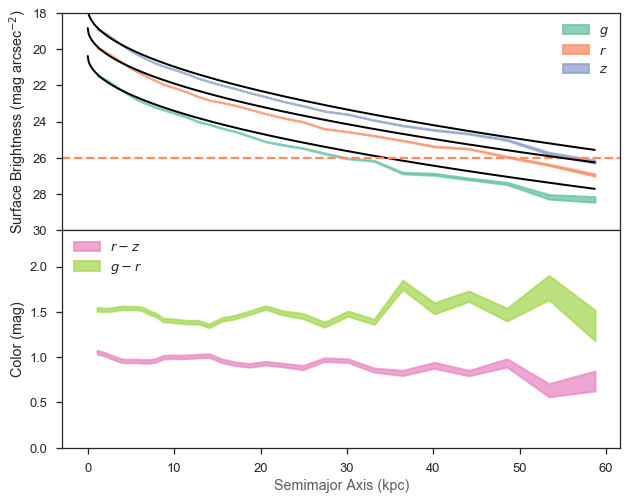

In [28]:
display_ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                          redshift=redshift, pixscale=pixscale,
                          sersicfit=sersicfit)

### Playing around below here

In [12]:
stop

NameError: name 'stop' is not defined

In [ ]:
stop

In [ ]:
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
smascale = 1
filt = 'r'
good = (ellipsefit[filt].stop_code < 4)
bad = ~good
fig, ax1 = plt.subplots()
ax1.fill_between(ellipsefit[filt].sma[good] * smascale, 
                 ellipsefit[filt].eps[good]-ellipsefit[filt].ellip_err[good],
                 ellipsefit[filt].eps[good]+ellipsefit[filt].ellip_err[good],
                 edgecolor='k', lw=2)

#ax1.errorbar(ellipsefit[filt].sma[good] * smascale,
#             ellipsefit[filt].eps[good],
#             ellipsefit[filt].ellip_err[good], marker='s', linestyle='none',
#             capsize=10, capthick=2, 
#             markersize=10)#, color=color[filt])
ax1.scatter(ellipsefit[filt].sma[bad] * smascale,
             ellipsefit[filt].eps[bad], marker='s', s=40, edgecolor='k', lw=2, alpha=0.75)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())